<a href="https://colab.research.google.com/github/gcvasconcelos/unb-classification_political_bias/blob/main/tcc_manifestos_2preprocessamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 22.2 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
import pandas as pd
import pickle
import dateutil.parser
from unidecode import unidecode
import spacy
import re
import time
from collections import defaultdict

# Pré-processamento da base de sentenças


In [ ]:
raw_sentences = pd.read_csv('/content/drive/MyDrive/UnB/TCC/dados_processados/manifestos_sentences.csv', keep_default_na=False)
raw_sentences.info()
raw_sentences.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92041 entries, 0 to 92040
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   manifest_id  92041 non-null  object
 1   text         92041 non-null  object
 2   domain_code  92041 non-null  int64 
 3   domain_name  92041 non-null  object
 4   code         92041 non-null  object
 5   label        92041 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.2+ MB


,manifest_id,text,domain_code,domain_name,code,label
0,180110_201010,Agenda por um Brasil Justo e Sustentável,0,No Domain,NA,uncoded
1,180110_201010,Propostas de Marina Silva e do Partido Verde p...,0,No Domain,NA,uncoded
2,180110_201010,As propostas foram elaboradas a partir das Dir...,0,No Domain,NA,uncoded
3,180110_201010,Transparência e ética,0,No Domain,NA,uncoded
4,180110_201010,Não instituicão de qualquer mecanismo de tutel...,2,Freedom and Democracy,201.2,human rights


## Padronização

In [ ]:
def standardize_dataframe(df, text_column, target_column):
    df[text_column] = df[text_column].str.lower()
    df[text_column] = df[text_column].apply(unidecode)

    df[target_column] = df[target_column].astype(str)
    df[target_column] = df[target_column].str.upper()
    df[target_column] = df[target_column].apply(unidecode)

    df.columns = [str(col).upper().strip() for col in df.columns]
    print(df.info())

standardize_dataframe(raw_sentences, 'text', 'code')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92041 entries, 0 to 92040
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MANIFEST_ID  92041 non-null  object
 1   TEXT         92041 non-null  object
 2   DOMAIN_CODE  92041 non-null  int64 
 3   DOMAIN_NAME  92041 non-null  object
 4   CODE         92041 non-null  object
 5   LABEL        92041 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.2+ MB
None


In [ ]:
raw_sentences.TEXT

0                 agenda por um brasil justo e sustentavel
1        propostas de marina silva e do partido verde p...
2        as propostas foram elaboradas a partir das dir...
3                                    transparencia e etica
4        nao instituicao de qualquer mecanismo de tutel...
                               ...                        
92036    e isto so e possivel se os custos de "empregab...
92037    5.a flexibilizacao dos salarios pela aplicacao...
92038    6.alteracao dos horarios de trabalho especialm...
92039    7.fixacao de uma idade a partir de qual a refo...
92040    8.a legislacao devera equiparar os trabalhador...
Name: TEXT, Length: 92041, dtype: object

## Limpeza e Remoção de stop words

In [ ]:
regex_dict = {
    r"\\n|\\xa0": " "
    , r"[^a-zÀ-ÿ]": " "
    , r"\b[a-zÀ-ÿ]{1,2}\b": " "
    , r"\s+": " "
}

regex = {re.compile(k): v for k, v in regex_dict.items()}

def parse_text(text):
    for pattern, replacement in regex.items():
        text = pattern.sub(replacement, text)
    return text

def text_cleaning(df, text_column):
    clean_text = df[text_column].str.lower()
    clean_text = clean_text.apply(unidecode)
    clean_text = clean_text.apply(parse_text)
    clean_text = clean_text.str.strip()

    return clean_text

t = time.time()
raw_sentences['TEXT_CLEAN'] = text_cleaning(raw_sentences, 'TEXT')
print(f'Tempo de processamento da limpeza do texto: {round((time.time() - t) / 60, 2)} mins')

Tempo de processamento da limpeza do texto: 0.03 mins


In [ ]:
raw_sentences[['TEXT', 'TEXT_CLEAN']]

,TEXT,TEXT_CLEAN
0,agenda por um brasil justo e sustentavel,agenda por brasil justo sustentavel
1,propostas de marina silva e do partido verde p...,propostas marina silva partido verde para cand...
2,as propostas foram elaboradas a partir das dir...,propostas foram elaboradas partir das diretriz...
3,transparencia e etica,transparencia etica
4,nao instituicao de qualquer mecanismo de tutel...,nao instituicao qualquer mecanismo tutela cont...
...,...,...
92036,"e isto so e possivel se os custos de ""empregab...",isto possivel custos empregabilidade salarios ...
92037,5.a flexibilizacao dos salarios pela aplicacao...,flexibilizacao dos salarios pela aplicacao max...
92038,6.alteracao dos horarios de trabalho especialm...,alteracao dos horarios trabalho especialmente ...
92039,7.fixacao de uma idade a partir de qual a refo...,fixacao uma idade partir qual reforma torne fa...


In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
import nltk

nltk.download('stopwords') 

stopwords_set = set(STOP_WORDS)\
                    .union(set(nltk.corpus.stopwords.words('portuguese')))
stopwords_set = {unidecode(s) for s in stopwords_set}
# stopwords_set

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stopwords(doc):
    corpus = [token for token in doc.split() if token not in stopwords_set]
    return corpus

t = time.time()

raw_sentences['TEXT_TOKEN'] = raw_sentences['TEXT_CLEAN'].apply(remove_stopwords)

print(f'Tempo de processamento tokenização: {round((time.time() - t) / 60, 2)} mins')
" ".join(raw_sentences['TEXT_TOKEN'].iat[1])

Tempo de processamento tokenização: 0.01 mins


'propostas marina silva partido verde candidatos turno campanha presidencial buscando compromissos programaticos brasil justo sustentavel construcao governabilidade base principios valores eticos'

In [ ]:
raw_sentences['TEXT_TOKEN'] = raw_sentences['TEXT_TOKEN'].apply(lambda x: ' '.join(x))
raw_sentences[['TEXT', 'TEXT_TOKEN']]

,TEXT,TEXT_TOKEN
0,agenda por um brasil justo e sustentavel,agenda brasil justo sustentavel
1,propostas de marina silva e do partido verde p...,propostas marina silva partido verde candidato...
2,as propostas foram elaboradas a partir das dir...,propostas elaboradas diretrizes programa gover...
3,transparencia e etica,transparencia etica
4,nao instituicao de qualquer mecanismo de tutel...,instituicao mecanismo tutela controle liberdad...
...,...,...
92036,"e isto so e possivel se os custos de ""empregab...",custos empregabilidade salarios restricoes leg...
92037,5.a flexibilizacao dos salarios pela aplicacao...,flexibilizacao salarios aplicacao maxima salar...
92038,6.alteracao dos horarios de trabalho especialm...,alteracao horarios trabalho especialmente resp...
92039,7.fixacao de uma idade a partir de qual a refo...,fixacao idade reforma torne facultativa obriga...


## Lematização

In [ ]:
nlp = spacy.load('pt_core_news_sm', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe('sentencizer')

In [ ]:
from joblib import Parallel, delayed

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def remove_stopwords(doc):
    corpus = [unidecode(token.lemma_) for token in doc if (token.text not in stopwords_set) and (token.pos_ != 'PROPN')]
    return corpus

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=25):
        preproc_pipe.append(remove_stopwords(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=1000):
    executor = Parallel(n_jobs=2, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(raw_sentences), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

t = time.time()

raw_sentences['TEXT_LEMMA'] = preprocess_parallel(raw_sentences['TEXT_CLEAN'])

print(f'Tempo de processamento lemmatização: {round((time.time() - t) / 60, 2)} mins')

Tempo de processamento lemmatização: 1.29 mins


In [ ]:
raw_sentences['TEXT_LEMMA'] = raw_sentences['TEXT_LEMMA'].apply(lambda x: ' '.join(x))
raw_sentences[['TEXT', 'TEXT_TOKEN', 'TEXT_LEMMA']]

,TEXT,TEXT_TOKEN,TEXT_LEMMA
0,agenda por um brasil justo e sustentavel,agenda brasil justo sustentavel,agendar justar sustentavel
1,propostas de marina silva e do partido verde p...,propostas marina silva partido verde candidato...,proposto partir ver candidato turno campanha p...
2,as propostas foram elaboradas a partir das dir...,propostas elaboradas diretrizes programa gover...,proposto elaborar diretrizes programar governa...
3,transparencia e etica,transparencia etica,transparencia etica
4,nao instituicao de qualquer mecanismo de tutel...,instituicao mecanismo tutela controle liberdad...,instituicao mecanismo tutelar controlo liberda...
...,...,...,...
92036,"e isto so e possivel se os custos de ""empregab...",custos empregabilidade salarios restricoes leg...,custo empregabilidade salarios restricoes lega...
92037,5.a flexibilizacao dos salarios pela aplicacao...,flexibilizacao salarios aplicacao maxima salar...,flexibilizacao salarios aplicacao maxima salar...
92038,6.alteracao dos horarios de trabalho especialm...,alteracao horarios trabalho especialmente resp...,alteracao horarios trabalhar especialmente res...
92039,7.fixacao de uma idade a partir de qual a refo...,fixacao idade reforma torne facultativa obriga...,fixacao idade reformar tornar facultativo obri...


In [ ]:
index = 1
print(raw_sentences['TEXT'].iat[index])
print(raw_sentences['TEXT_TOKEN'].iat[index])
print(raw_sentences['TEXT_LEMMA'].iat[index])

propostas de marina silva e do partido verde para os candidatos ao segundo turno da campanha presidencial buscando compromissos programaticos para um brasil justo e sustentavel, a construcao da governabilidade com base em principios e valores eticos.
propostas marina silva partido verde candidatos turno campanha presidencial buscando compromissos programaticos brasil justo sustentavel construcao governabilidade base principios valores eticos
proposto partir ver candidato turno campanha presidencial buscar compromisso programaticos justar sustentavel construcao governabilidade base principios valorar eticos


Remove sentenças que ficaram vazias após a limpeza

In [ ]:
raw_sentences[raw_sentences['TEXT_LEMMA'] == ''][['TEXT', 'TEXT_CLEAN', 'TEXT_TOKEN', 'TEXT_LEMMA']]

,TEXT,TEXT_CLEAN,TEXT_TOKEN,TEXT_LEMMA
271,para nos tambem.,para nos tambem,,
500,e o que mais se ve por ai.,que mais por,,
585,do estado,estado,,
680,para nada.,para nada,,
730,ha mais.,mais,,
...,...,...,...,...
90777,o estado tem de dar o exemplo,estado tem dar exemplo,,
91012,onde estamos,onde estamos,,
91077,e ainda bem que assim e.,ainda bem que assim,,
91097,e por ai fora.,por fora,,


In [ ]:
print('Número de sentenças vazias a pó a limpeza: ', len(raw_sentences[raw_sentences['TEXT_LEMMA'] == '']))
sentences = raw_sentences[raw_sentences['TEXT_LEMMA'] != '']
print('Número de sentenças válidas após a limpeza: ', len(sentences))

Número de sentenças vazias a pó a limpeza:  753
Número de sentenças válidas após a limpeza:  91288


## Balanceamento

In [ ]:
sentences['CODE'].value_counts()

NA       8946
504      7860
411      7136
506      5248
503      5051
         ... 
703.2      13
608.1       6
305.6       2
608.2       2
102         1
Name: CODE, Length: 86, dtype: int64

In [ ]:
sentences_foo = sentences.copy()

In [ ]:
def sample_target(df, target_column, min_obs):
    classes_dist = df[target_column].value_counts().reset_index().rename(columns={
        'index': target_column
        , target_column: 'NUM_AMOSTRAS'
    })

    classe_outros = classes_dist[classes_dist['NUM_AMOSTRAS'] <= min_obs][target_column]
    print(f"Número de classes com menos de {min_obs} amostras : {len(classe_outros)}\nNúmero de classes final: {len(classes_dist)-len(classe_outros)}")

    nome_amostra = target_column + '_SAMPLE'
    df[nome_amostra] = df[target_column]
    df.loc[df[nome_amostra].isin(classe_outros), nome_amostra] = "OTHERS"

    print(df[nome_amostra].value_counts())

sample_target(sentences, 'CODE', 1000)

Número de classes com menos de 1000 amostras : 64
Número de classes final: 22
OTHERS    17841
NA         8946
504        7860
411        7136
506        5248
503        5051
303        4672
501        3900
502        3045
202.1      2879
416.2      2803
701        2717
410        2559
402        2296
605.1      2235
703.1      2011
403        2008
414        1753
301        1741
401        1225
304        1171
408        1112
305.1      1079
Name: CODE_SAMPLE, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Removendo classes com menos de 1000 sentenças e com a classe "Uncoded"

In [ ]:
sentences = sentences[~sentences['CODE_SAMPLE'].isin(['OTHERS', 'NA'])]
sentences.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64501 entries, 5 to 92040
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MANIFEST_ID  64501 non-null  object
 1   TEXT         64501 non-null  object
 2   DOMAIN_CODE  64501 non-null  int64 
 3   DOMAIN_NAME  64501 non-null  object
 4   CODE         64501 non-null  object
 5   LABEL        64501 non-null  object
 6   TEXT_CLEAN   64501 non-null  object
 7   TEXT_TOKEN   64501 non-null  object
 8   TEXT_LEMMA   64501 non-null  object
 9   CODE_SAMPLE  64501 non-null  object
dtypes: int64(1), object(9)
memory usage: 5.4+ MB


## Análise descritiva

Estatísticas descritivas para o texto limpo: 
count    64501.000000
mean        10.858219
std          6.585926
min          1.000000
25%          6.000000
50%         10.000000
75%         14.000000
max        152.000000
Name: WORD_FREQ, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


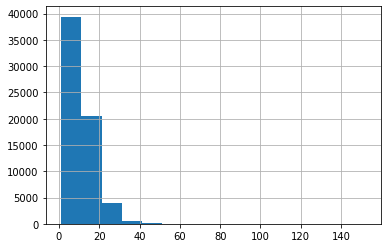

In [ ]:
sentences['WORD_FREQ'] = sentences['TEXT_TOKEN'].apply(lambda x : len(x.split()))
print(f"Estatísticas descritivas para o texto limpo: \n{sentences['WORD_FREQ'].describe()}")
sentences['WORD_FREQ'].hist(bins = 15)

In [ ]:
sentences['WORD_FREQ'].quantile(q=0.99)

31.0

In [ ]:
faixa_corte = sentences['WORD_FREQ'].quantile(q=0.99)
sentences[sentences['WORD_FREQ'] > faixa_corte]['CODE'].value_counts()

504      73
501      60
411      49
506      49
503      36
416.2    33
502      32
202.1    31
303      28
403      27
402      23
701      23
605.1    22
410      20
301      15
408      13
414      13
703.1    12
304      10
305.1     7
401       6
Name: CODE, dtype: int64

Estatísticas descritivas para o texto limpo: 
count    63919.000000
mean        10.623555
std          6.090052
min          1.000000
25%          6.000000
50%         10.000000
75%         14.000000
max         31.000000
Name: WORD_FREQ, dtype: float64


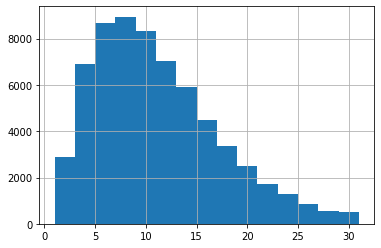

In [ ]:
clean_sentences = sentences[sentences['WORD_FREQ'] <= faixa_corte]
print(f"Estatísticas descritivas para o texto limpo: \n{clean_sentences['WORD_FREQ'].describe()}")
clean_sentences['WORD_FREQ'].hist(bins = 15)

In [ ]:
corpus_array = [doc.split() for doc in clean_sentences['TEXT_TOKEN']]
word_frequency = defaultdict(int)
for sentence in corpus_array:
    for word in sentence:
        word_frequency[word] += 1
print(f"Vocabulary present in corpus: {len(word_frequency)}")
print("Most frequent words in corpus:")
sorted(word_frequency, key=word_frequency.get, reverse=True)[:15]

Vocabulary present in corpus: 35235
Most frequent words in corpus:


['nacional',
 'social',
 'desenvolvimento',
 'politica',
 'saude',
 'governo',
 'pais',
 'servicos',
 'recursos',
 'trabalho',
 'empresas',
 'politicas',
 'programa',
 'ensino',
 'anos']

In [ ]:
corpus_array = [doc.split() for doc in clean_sentences['TEXT_LEMMA']]
word_frequency = defaultdict(int)
for sentence in corpus_array:
    for word in sentence:
        word_frequency[word] += 1
print(f"Vocabulary present in corpus: {len(word_frequency)}")
print("Most frequent words in corpus:")
sorted(word_frequency, key=word_frequency.get, reverse=True)[:15]

Vocabulary present in corpus: 20671
Most frequent words in corpus:


['politicar',
 'publicar',
 'social',
 'nacional',
 'programar',
 'desenvolvimento',
 'garantir',
 'saude',
 'recurso',
 'pai',
 'governar',
 'trabalhar',
 'ano',
 'servicos',
 'empresar']

## Salvar base de dados

In [ ]:
clean_sentences.info()
clean_sentences.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63919 entries, 5 to 92040
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MANIFEST_ID  63919 non-null  object
 1   TEXT         63919 non-null  object
 2   DOMAIN_CODE  63919 non-null  int64 
 3   DOMAIN_NAME  63919 non-null  object
 4   CODE         63919 non-null  object
 5   LABEL        63919 non-null  object
 6   TEXT_CLEAN   63919 non-null  object
 7   TEXT_TOKEN   63919 non-null  object
 8   TEXT_LEMMA   63919 non-null  object
 9   CODE_SAMPLE  63919 non-null  object
 10  WORD_FREQ    63919 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 5.9+ MB


,MANIFEST_ID,TEXT,DOMAIN_CODE,DOMAIN_NAME,CODE,LABEL,TEXT_CLEAN,TEXT_TOKEN,TEXT_LEMMA,CODE_SAMPLE,WORD_FREQ
5,180110_201010,transparencia das informacoes sobre execucao o...,2,Freedom and Democracy,202.1,democracy: general +,transparencia das informacoes sobre execucao o...,transparencia informacoes execucao orcamentari...,transparencia informacoes orcamentaria governa...,202.1,16
8,180110_201010,encaminhamento ao congresso de reforma politic...,2,Freedom and Democracy,202.1,democracy: general +,encaminhamento congresso reforma politica com ...,encaminhamento congresso reforma politica adoc...,encaminhamento congresso reformar politicar ad...,202.1,13
10,180110_201010,elevacao do investimento em educacao do setor ...,5,Welfare and Quality of Life,506,education +,elevacao investimento educacao setor publico p...,elevacao investimento educacao setor publico p...,elevacao investimento educacao setor publicar ...,506,14
11,180110_201010,eliminacao do analfabetismo entre jovens de 15...,5,Welfare and Quality of Life,506,education +,eliminacao analfabetismo entre jovens anos ate,eliminacao analfabetismo jovens anos,eliminacao analfabetismo jovem ano,506,4
12,180110_201010,e erradicacao do analfabetismo ate 2018;,5,Welfare and Quality of Life,506,education +,erradicacao analfabetismo ate,erradicacao analfabetismo,erradicacao analfabetismo,506,2


In [ ]:
clean_sentences = clean_sentences[['MANIFEST_ID', 'TEXT', 'TEXT_TOKEN', 'TEXT_LEMMA', 'DOMAIN_CODE', 'DOMAIN_NAME', 'CODE', 'LABEL']]
clean_sentences.to_csv('/content/drive/MyDrive/UnB/TCC/dados_processados/manifestos_sentences_preproc_v2.csv', index=False)

# Pré processamento da base de Manifestos

In [ ]:
manifestos_df = pd.read_csv('/content/drive/MyDrive/UnB/TCC/datasets/manifestos_texts.csv')
manifestos_df.info()
manifestos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   manifest_id  102 non-null    object
 1   text         102 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


,manifest_id,text
0,180110_201010,Agenda por um Brasil Justo e Sustentável Propo...
1,180230_198911,DЕМОСRАCIА Еѕtаdо Роdеr Јudiсiáriо Соrruрçãо С...
2,180230_199410,INTRODUÇÃO O Brasil é um país viável desde que...
3,180230_199810,UNIÃO DO POVO – MUDA BRASIL Diretrizes do Prog...
4,180230_200210,"Um Brasil para Todos Crescimento, Emprego e In..."


In [ ]:
manifestos_df.loc[0,'text']

'Agenda por um Brasil Justo e Sustentável Propostas de Marina Silva e do Partido Verde para os candidatos ao segundo turno da campanha presidencial buscando compromissos programáticos para um Brasil Justo e Sustentável, a construção da governabilidade com base em princípios e valores éticos. As propostas foram elaboradas a partir das Diretrizes para o Programa de Governo da Candidatura de Marina Silva à Presidência da República “Juncos pelo Brasil que Queremos”, aprovadas pela Convenção do Partido Verde e publicadas no dia 10 de junho de 2010, actualizadas e divulgadas em julho de 2010 para discussão aberta com a sociedade na campanha presidencia1e com novos aportes recebidos no curso desta. Transparência e ética Não instituicão de qualquer mecanismo de tutela ou controle sobre a liberdade de imprensa; Transparência das informações sobre execução orçamentária do governo federal disponibilizando na internet dados primários do Sistema lntegrado de Administração Financeira do Governo Fede

Estatísticas descritivas para o texto: 
count       102.000000
mean      26608.519608
std       29452.484542
min         607.000000
25%        2763.250000
50%       12235.500000
75%       46149.000000
max      123395.000000
Name: text, dtype: float64


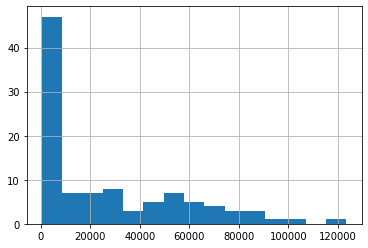

In [ ]:
word_count = manifestos_df['text'].apply(lambda x : len(x.split(" ")))
print(f"Estatísticas descritivas para o texto: \n{word_count.describe()}")
word_count.hist(bins = 15)

In [ ]:
contraction_dict = {
    "v\. exa": "vossa excelencia"
    ,"s\. exa": "vossa excelencia"
    , "sr\.": "senhor"
    , "sr": "senhor"
    , "srs\.": "senhores"
    , "sra\.": "senhora"
    , "sra": "senhora"
    , "sras\.": "senhoras"
    , "pag\.": "pagina"
    , "exm\.": "excelentissimo"
    , "exma\.": "excelentissima"
}
contraction_comp = {re.compile(fr"\b{k}\b"): v for k, v in contraction_dict.items()}
regex_dict = {
    r"\\n|\\xa0": " "
    , r"[^a-zÀ-ÿ]": " "
    , r"\b[a-zÀ-ÿ]{1,2}\b": " "
    , r"\s+": " "
}
regex_comp = {re.compile(k): v for k, v in regex_dict.items()}

regex = {**contraction_comp, **regex_comp}

def parse_text(text):
    for pattern, replacement in regex.items():
        text = pattern.sub(replacement, text)
    return text

def text_cleaning(df, text_column):
    new_column = text_column + "_clean"
    df[new_column] = df[text_column].str.lower()
    df[new_column] = df[new_column].apply(parse_text)
    df[new_column] = df[new_column].str.strip()

t = time.time()
text_cleaning(manifestos_df, 'text')
print(f'Tempo de processamento da limpeza do texto: {round((time.time() - t) / 60, 2)} mins')
manifestos_df['text_clean'].iat[0]

Tempo de processamento da limpeza do texto: 0.13 mins


'agenda por brasil justo sustentável propostas marina silva partido verde para candidatos segundo turno campanha presidencial buscando compromissos programáticos para brasil justo sustentável construção governabilidade com base princípios valores éticos propostas foram elaboradas partir das diretrizes para programa governo candidatura marina silva presidência república juncos pelo brasil que queremos aprovadas pela convenção partido verde publicadas dia junho actualizadas divulgadas julho para discussão aberta com sociedade campanha presidencia com novos aportes recebidos curso desta transparência ética não instituicão qualquer mecanismo tutela controle sobre liberdade imprensa transparência das informações sobre execução orçamentária governo federal disponibilizando internet dados primários sistema lntegrado administração financeira governo federal siafi permitindo acompanhamento execução dos contratos dos processos decisórios inclusive dos conselhos governo agências reguladoras refor

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
import nltk

nltk.download('stopwords') 

stopwords_set = set(STOP_WORDS)\
                    .union(set(nltk.corpus.stopwords.words('portuguese')))\
                    .union(set(['mdb', 'ptb', 'pdt', 'pt', 'dem', 'pcdob', 'psb', 
                                'psdb', 'ptc', 'psc', 'pmn', 'pv', 'pp', 'pstu', 
                                'pcb', 'prtb', 'dc', 'pco', 'pode', 'psl', 'psol', 
                                'pl', 'psd', 'pmb', 'up']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(doc):
    corpus = [unidecode(token) for token in doc.split() if token not in stopwords_set]
    return corpus

t = time.time()

manifestos_df['text_token'] = manifestos_df['text_clean'].apply(remove_stopwords)

print(f'Tempo de processamento tokenização: {round((time.time() - t) / 60, 2)} mins')
" ".join(manifestos_df['text_token'].iat[0])

Tempo de processamento tokenização: 0.07 mins


'agenda brasil justo sustentavel propostas marina silva partido verde candidatos turno campanha presidencial buscando compromissos programaticos brasil justo sustentavel construcao governabilidade base principios valores eticos propostas elaboradas diretrizes programa governo candidatura marina silva presidencia republica juncos brasil queremos aprovadas convencao partido verde publicadas dia junho actualizadas divulgadas julho discussao aberta sociedade campanha presidencia aportes recebidos curso transparencia etica instituicao mecanismo tutela controle liberdade imprensa transparencia informacoes execucao orcamentaria governo federal disponibilizando internet dados primarios lntegrado administracao financeira governo federal siafi permitindo acompanhamento execucao contratos processos decisorios conselhos governo agencias reguladoras reforma eleitoral encaminhamento congresso reforma politica adocao voto distrital misto lista civica financiamento publico campanhas educacao sociedade

In [ ]:
nlp = spacy.load('pt_core_news_lg', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe('sentencizer')

In [ ]:
from joblib import Parallel, delayed

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def remove_stopwords(doc):
    corpus = [unidecode(token.lemma_) for token in doc if (token.text not in stopwords_set) and (token.pos_ != 'PROPN')]
    return corpus

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=5):
        preproc_pipe.append(remove_stopwords(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=50):
    executor = Parallel(n_jobs=2, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(manifestos_df), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

t = time.time()

manifestos_df['text_lemma'] = preprocess_parallel(manifestos_df['text_clean'])

print(f'Tempo de processamento tokenização: {round((time.time() - t) / 60, 2)} mins')

Tempo de processamento tokenização: 1.85 mins


### Analysis

Estatísticas descritivas para o texto: 
count      102.000000
mean     12741.696078
std      14116.693777
min        245.000000
25%       1277.250000
50%       5930.500000
75%      22475.500000
max      58992.000000
Name: text_lemma, dtype: float64


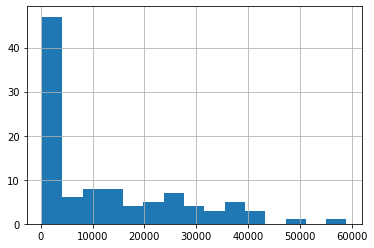

In [ ]:
word_count = manifestos_df['text_lemma'].apply(lambda x : len(x))
print(f"Estatísticas descritivas para o texto: \n{word_count.describe()}")
word_count.hist(bins = 15)

In [ ]:
corpus_array = [doc for doc in manifestos_df['text_lemma']]
word_frequency = defaultdict(int)
for sentence in corpus_array:
    for word in sentence:
        word_frequency[word] += 1
print(f"Vocabulary present in corpus: {len(word_frequency)}")
print("Most frequent words in corpus:")
sorted(word_frequency, key=word_frequency.get, reverse=True)[:15]

Vocabulary present in corpus: 23581
Most frequent words in corpus:


['politico',
 'publico',
 'social',
 'nacional',
 'pais',
 'desenvolvimento',
 'servico',
 'programar',
 'garantir',
 'governar',
 'trabalhar',
 'direito',
 'empresar',
 'ano',
 'recurso']